## setup and notebook configuration

In [1]:
# scientific python stack
import numpy as np
import scipy as sp
import sympy as sym
import orthopy, quadpy

In [2]:
# matplotlib, plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as mtri               # delaunay triangulation
from mpl_toolkits.mplot3d import Axes3D     # surface plotting
import seaborn as sns                       # nice plotting defaults
import cmocean as cmo                       # ocean colormaps
sym.init_printing(use_latex='mathjax')
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# local imports
import src.fem_base.master.mk_basis_nodal as mbn
import src.fem_base.master.mk_master as mkm

# creating nodal bases

## 1D basis

make a nodal basis on the master 1D element

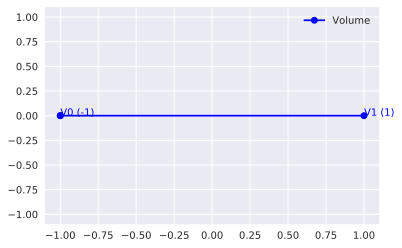

In [5]:
b = mbn.Basis_nodal(order=1, dim=1, element=0)
b.plot_elm()

each Basis_nodal object has an `eval_at_pts` method which can evaluate the basis at a given set of points. We can use this function to plot the basis functions over the element. Clunky, but this was originally written to accept input like `[[x1, y1, z1], [x2, y2, z2], ]`

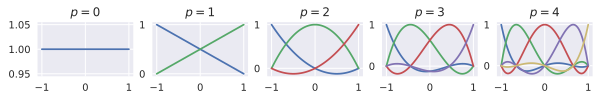

In [6]:
fig, ax = plt.subplots(1, 5, figsize = (10, 1))
xx = np.linspace(-1, 1, 100)
pts = [[x, 0, 0] for x in xx]

for order in range(5):
    b = mbn.Basis_nodal(order=order, dim=1, element=0)
    yy = b.eval_at_pts(pts=pts)
    for basis_fn in range(b.nb):
        ax[order].plot(xx, yy[:, basis_fn])
    ax[order].set_title(r'$p = {}$'.format(order))

## construction of vandermonde matrices

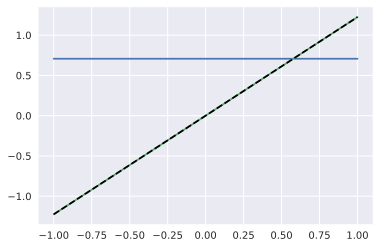

In [7]:
x = np.linspace(-1, 1, 10)
vals = orthopy.line_segment.tree_jacobi(x, n=4, alpha=0, beta=0, standardization='normal')
plt.plot(x, vals[0])
plt.plot(x, vals[1])
p2 = np.sqrt(3./2)*x
plt.plot(x, p2, 'k--')

In [8]:
def Jacobi_Poly(r, alpha, beta, N):
    """ wraps orthopy to return Jacobi polynomial """
    return orthopy.line_segment.tree_jacobi(r, n=N-1, alpha=alpha, beta=beta, standardization='normal')

def P_tilde(r, N):
    P = np.zeros((len(r), N))
    polyvals = Jacobi_Poly(r, alpha=0, beta=0, N=N)
    for j in range(N):
        P[:, j] = polyvals[j]
    return P.T
    
def Vandermonde1D(N, x):
    """ initialize 1D vandermonde Matrix Vij = phi_j(x_i)"""
    V1D = np.zeros((len(x), N))
    JacobiP = Jacobi_Poly(x, alpha=0, beta=0, N=N)
    for j, polyvals in enumerate(JacobiP):
        V1D[:, j] = polyvals
    return V1D

In [9]:
def LegendreGaussLobatto(N):
    GL = quadpy.line_segment.GaussLobatto(N, a=0., b=0.)
    return GL.points, GL.weights

An important conceptual point is that the Vandermonde matrix here is NOT the shape function matrix, it's the Vandermonde matrix of the Orthonormal polynomial basis.

## properties / conditioning of vandermonde matrices

In [10]:
equi_det, LGL_det = [], []
for N in range(2, 35):
    equi_pts = np.linspace(-1, 1, N)
    V = Vandermonde1D(N, equi_pts)
    equi_det.append(np.linalg.det(V))
    
    LGL_pts, _ = LegendreGaussLobatto(N)
    V = Vandermonde1D(N, LGL_pts)
    LGL_det.append(np.linalg.det(V))

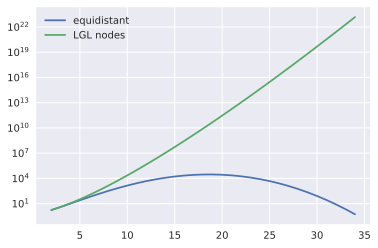

In [11]:
plt.semilogy(list(range(2, 35)), equi_det, label='equidistant')
plt.semilogy(list(range(2, 35)), LGL_det, label='LGL nodes')
plt.legend()
plt.show()

This result agrees with Hesthaven.

In [12]:
# construct generic lagrange interpolant
from scipy.interpolate import lagrange

def lagrange_polys(pts):
    lagrange_polys = []
    for i, pt in enumerate(pts):
        data = np.zeros_like(pts)
        data[i] = 1
        lagrange_polys.append(lagrange(pts, data))
    return lagrange_polys

def lagrange_basis_at_pts(lagrange_polys, eval_pts):
    """ evaluates lagrange polynomials at eval_pts"""
    result = np.zeros((len(lagrange_polys) ,len(eval_pts)))
    for i, poly in enumerate(lagrange_polys):
        result[i, :] = lagrange_polys[i](eval_pts)
    return result

plot lagrange polys over equally spaced vs LGL points

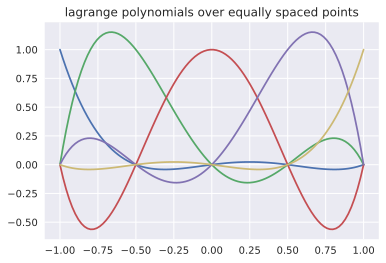

In [13]:
N = 5
lp = np.linspace(-1, 1, N)
lpolys = lagrange_polys(lp)

vN = 100
view_pts = np.linspace(-1, 1, vN)
li = lagrange_basis_at_pts(lpolys, view_pts)
plt.plot(view_pts, li.T)
plt.title('lagrange polynomials over equally spaced points')
plt.show()

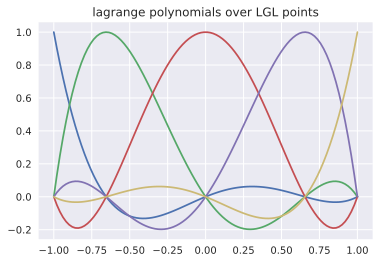

In [14]:
N = 5
lp, _ = LegendreGaussLobatto(N)
lpolys = lagrange_polys(lp)

vN = 100
view_pts = np.linspace(-1, 1, vN)
li = lagrange_basis_at_pts(lpolys, view_pts)
plt.plot(view_pts, li.T)
plt.title('lagrange polynomials over LGL points')
plt.show()

So beautiful! By moving the lagrange data points to the nodal points, our basis functions don't exceed 1, unlike in the above plot, where we are already seeing a slight Runge phenomenon.

## vandermonde relations

### relationship between vandermonde $V$, basis polynomials $\tilde{\mathbf{P}}$, and lagrange basis functions (shape functions) $\ell$

Hesthaven makes the claim that $V^T \mathbf{\ell}(r) = \tilde{\mathbf{P}}(r)$ in (3.3).

In Hesthaven's notation, $N$ denotes the polynomial order, $N_p$ denotes the number of nodal points (we would call $nb$), and let's call the number of "view points" `xx`, which are arbitrary.

Then the shapes of the Hesthaven structures are:
- $\mathbf{\ell}$, $\tilde{\mathbf{P}}$, $V$ are all (`nb`, `xx`)
- $V^T \ell$ is (`xx`, `nb`) x (`nb`, `xx`) $\rightarrow$ (`xx`, `xx`) where rows contain the values of polynomials $\tilde{\mathbf{P}}$

This works for either equidistant points or the LGL points.

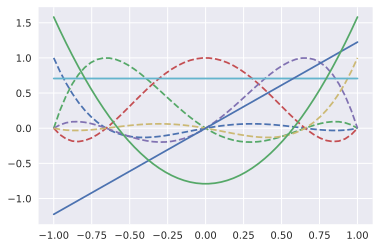

In [15]:
N = 5
lp, _ = LegendreGaussLobatto(N) 
#lp = np.linspace(-1, 1, N)
view_pts = np.linspace(-1, 1, 50)

l_polys = lagrange_polys(pts=lp)
ℓ = lagrange_basis_at_pts(l_polys, eval_pts=view_pts)
V = Vandermonde1D(N=len(view_pts), x=lp)
P = np.dot(V.T, ℓ)

# plot the result
plt.plot(view_pts, ℓ.T, '--')
plt.plot(view_pts, P[0:3,:].T)
plt.show()

We see that indeed we recover the Legendre polynomials.

More directly, we can invert the relation to find that

$$\ell = (V^T)^{-1} \tilde{\mathbf{P}}$$

which allows us to create our nodal shape functions.

shape of Vandermonde: (4, 4)
shape of P: (4, 50)


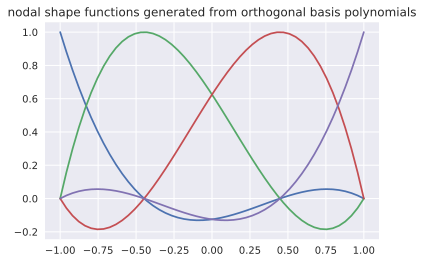

In [16]:
nb = 4
nodal_pts, _ = LegendreGaussLobatto(nb)
view_pts = np.linspace(-1, 1, 50)

# create the Vandermonde, P matrices
V = Vandermonde1D(N=nb, x=nodal_pts)
Vti = np.linalg.inv(V.T)
P = P_tilde(r=view_pts, N=nb)
print('shape of Vandermonde: {}'.format(V.shape))
print('shape of P: {}'.format(P.shape))

yy = np.dot(Vti, P)
plt.plot(view_pts, yy.T)
plt.title('nodal shape functions generated from orthogonal basis polynomials')
plt.show()

### relationship between vandermonde $V$ and mass matrix

We can build on the relationship developed in the section above to form the mass matrix for a nodal basis. We note that 

$M_{ij} = \int_{-1}^{1}\ell_i(r)\, \ell_j(r) \,dr = (\ell_i, \ell_j)_I$, and if we expand out $\ell = (V^T)^{-1}\tilde{\mathbf{P}}$, it turns out (page 51)

$$M = (V V^T)^{-1}$$

We can check this relation against the more traditional way of constructing the mass matrix with quadrature. `master.shap` has dimensions of (`n_quad`, `nb`)

In [17]:
order = 3
m1d = mkm.Master_nodal(order=order, dim=1, element=0)
xq, wq = m1d.cube_pts, m1d.cube_wghts
shap = m1d.shap
shapw = np.dot(np.diag(wq), m1d.shap)
M_quadrature = np.dot(shap.T, shapw)


Np = order + 1
nodal_points, _ = LegendreGaussLobatto(Np)
V = Vandermonde1D(N=Np, x=nodal_points)
M_vand = np.linalg.inv(np.dot(V, V.T))

# this will throw an error if not correct
assert(np.allclose(M_quadrature, M_vand))

## efficient computation of derivatives of the basis functions

In order to compute the derivatives of the shape functions (which are expressed via the vandermonde matrix $V$), we must take the derivatives with respect to the orthogonal basis polynomials. There is an identity (Hesthaven, p. 52)

$$ \frac{d \tilde{P}_n}{d r} = \sqrt{n(n+1)}\,\tilde{P}^{(1,1)}_{n-1}$$

This is in contrast to directly differentiating either the coefficients of $\tilde{P}$ or more directly the nodal shape functions $\ell$ if the explicit polynomial form is known (like in `scipy`, but this becomes trickier in multiple dimensions).

In [18]:
def Jacobi_Poly_Derivative(r, alpha, beta, N):
    """ take a derivative of Jacobi Poly, more general than above
    copy the format of orthopy (list of arrays)
    """
    dp = [np.zeros_like(r)] # n = 0
    Jacobi_P = Jacobi_Poly(r, alpha + 1, beta + 1, N-1)
    for n in range(1, N):
        gamma = np.sqrt(N * (N + alpha + beta + 1))
        dp.append(gamma * Jacobi_P[n-1])
    return dp

def dP_tilde(r, N):
    P = np.zeros((len(r), N))
    polyvals = Jacobi_Poly_Derivative(r, alpha=0, beta=0, N=N)
    for j in range(N):
        P[:, j] = polyvals[j]
    return P.T

We can declare the derivative Vandermonde matrix, and invert it in the same manner to obtain the derivatives of the nodal shape functions.

This works because 
$$V^T \ell = P \Rightarrow V^T \frac{d}{dx} \ell = \frac{d}{dx}P$$

In [19]:
def GradVandermonde1D(N, x):
    DVr = np.zeros((len(x), N))
    dJacobi_P = Jacobi_Poly_Derivative(x, alpha=0, beta=0, N=N)
    for j, polyder in enumerate(dJacobi_P):
        DVr[:,j] = polyder
    return DVr

shape Vr:    (50, 4)
shape V inv: (4, 4)
shape Dr:    (50, 4)


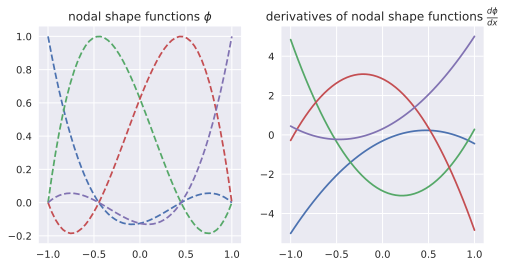

In [20]:
N = 3
nb = N+1
nodal_pts, _ = LegendreGaussLobatto(nb)
#nodal_pts = np.linspace(-1, 1, nb)
view_pts = np.linspace(-1, 1, 50)

# grad vandermonde
V  = Vandermonde1D(N=nb, x=nodal_pts)
Vr = GradVandermonde1D(N=nb, x=view_pts)
Vi = np.linalg.inv(V)
Dr = np.dot(Vr, Vi)

print('shape Vr:    {}'.format(Vr.shape))
print('shape V inv: {}'.format(Vi.shape))
print('shape Dr:    {}'.format(Dr.shape))

# shape functions
V = Vandermonde1D(N=nb, x=nodal_pts)
Vti = np.linalg.inv(V.T)
P = P_tilde(r=view_pts, N=nb)
shap = np.dot(Vti, P)


# shape functions at view points
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(view_pts, shap.T, '--')
ax[0].set_title(r'nodal shape functions $\phi$')
ax[1].plot(view_pts, Dr)
ax[1].set_title(r'derivatives of nodal shape functions $\frac{d \phi}{dx}$')
plt.show()

As a remark, we can once again show the effect of using Legendre Gauss Lobatto points vs equally spaced nodal points.

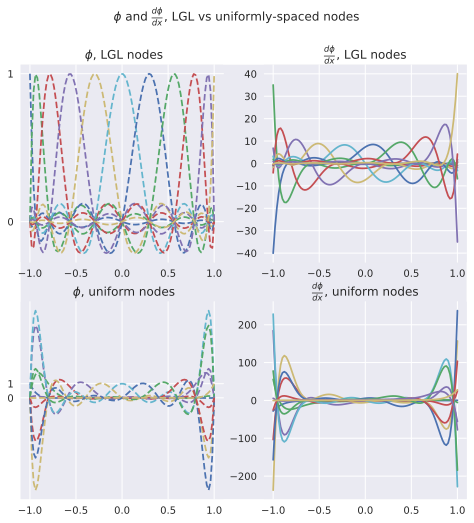

In [21]:
N = 10
nb = N+1
nodal_pts_LGL, _ = LegendreGaussLobatto(nb)
nodal_pts_equi = np.linspace(-1, 1, nb)
view_pts = np.linspace(-1, 1, 100)

# shape functions at view points
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([])
ax.set_xticks([])
labels = ['LGL nodes', 'uniform nodes']
for idx, nodal_pts in enumerate([nodal_pts_LGL, nodal_pts_equi]):
    # grad vandermonde
    V  = Vandermonde1D(N=nb, x=nodal_pts)
    Vr = GradVandermonde1D(N=nb, x=view_pts)
    Vi = np.linalg.inv(V)
    Dr = np.dot(Vr, Vi)

    # shape functions
    V = Vandermonde1D(N=nb, x=nodal_pts)
    Vti = np.linalg.inv(V.T)
    P = P_tilde(r=view_pts, N=nb)
    shap = np.dot(Vti, P)
    
    # plot
    ax = fig.add_subplot(2, 2, idx*2+1)
    ax.plot(view_pts, shap.T, '--')
    ax.set_yticks([0, 1])
    ax.set_title(r' $\phi$, {}'.format(labels[idx]))
    ax = fig.add_subplot(2, 2, idx*2+2)
    ax.plot(view_pts, Dr)
    ax.set_title(r'$\f{}$, {}'.format('rac{d \phi}{dx}',labels[idx]))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle(r'$\phi$ and $\frac{d\phi}{d x}$, LGL vs uniformly-spaced nodes')
plt.show()